# Análise de Anomalias em Série Temporal

BIMASTER - Trabalho de final de curso

Nome: Alex Marques Campos

## Configuração do ambiente de execução

In [1]:
# Garantimos que a versão do statsmodels está fixa com a versão que precisamos
# para a análise.
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels

from pandas.core.arrays import period
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
print(f'pandas == {pd.__version__}')
print(f'statsmodels == {statsmodels.__version__}')
print(f'matplotlib == {matplotlib.__version__}')

pandas == 1.3.5
statsmodels == 0.13.2
matplotlib == 3.2.2


In [4]:
NOME_DIRETORIO_SAIDA = 'dados'
NOME_ARQUIVO_SAIDA_SERIE_IBCBR = 'serie_ibcbr.csv'
NOME_ARQUIVO_SAIDA_SERIE_IBCBR_RESIDUO = 'serie_ibcbr_residuo.csv'
NOME_ARQUIVO_SAIDA_SERIE_IBCBR_DIFERENCAS = 'serie_ibcbr_diferencas.csv'
NOME_ARQUIVO_SAIDA_SERIE_IBCBR_DIFERENCAS_RESIDUO = 'serie_ibcbr_diferencas_residuo.csv'

In [5]:
# habilitamos a visualização especial de dataframes disponível no
# Google Colaboratory, para facilitar a exploração dos dados.
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [6]:
# ajustamos o formato de apresentação padrão dos gráficos
sns.set_theme(style="white", palette="pastel")

## Obtendo a série temporal
  A série temporal selecionada para análise foi o [Índice de Atividade Econômica do Banco Central - IBC-Br](https://dadosabertos.bcb.gov.br/dataset/24363-indice-de-atividade-economica-do-banco-central---ibc-br), que é um indicador mensal da atividade econômica no Brasil. Os dados dessa série iniciam em 2003 e são apurados mensalmente pelo banco central do Brasil. Essa série está íntimamente relacionada com a formação do Produto Interno Bruto do Brasil, servido como indicativo de tendência deste último.

Os dados da série podem ser obtidos diretamente do portal de dados abertos do banco central, via chamada de API.

In [7]:
# carga dos dados mais recentes via API do Banco Central do Brasil
df = pd.read_csv('http://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados?formato=csv', 
                 delimiter=';', 
                 decimal=',', 
                 parse_dates=['data'], 
                 index_col='data', 
                 dayfirst=True)

## Análise exploratória dos dados

### Análise da série original

#### Visualização básica dos dados

In [8]:
df.head()

,valor
data,
2003-01-01,96.15
2003-02-01,98.67
2003-03-01,103.41
2003-04-01,102.19
2003-05-01,100.30


In [9]:
df.describe()

,valor
count,236.000000
mean,131.194492
std,13.723696
min,96.150000
25%,122.417500
50%,135.825000
75%,141.190000
max,152.130000


In [10]:
df.shape

(236, 1)

In [11]:
# verificamos se há valores nulos na série histórica
# (até outubro de 2022, não havia nulos nos dados)
df.isna().sum()

valor    0
dtype: int64

In [12]:
display(df)

,valor
data,
2003-01-01,96.15
2003-02-01,98.67
2003-03-01,103.41
2003-04-01,102.19
2003-05-01,100.30
...,...
2022-04-01,142.10
2022-05-01,142.77
2022-06-01,141.93


#### Decomposição da série (tendência, sazonalidade e resíduos)

- A tendência indica a variação de longo prazo dos dados.
- A sazonalidade indica a presença de padrões periódicos nos dados.
- Resíduos são variações nos dados que não são explicados pela tendência ou sazonalidade.

O primeiro passo é a visualização dos dados, para fazermos uma análise visual da curva.

In [13]:
def configurar_ticks_anuais(ax):
  ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
  ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

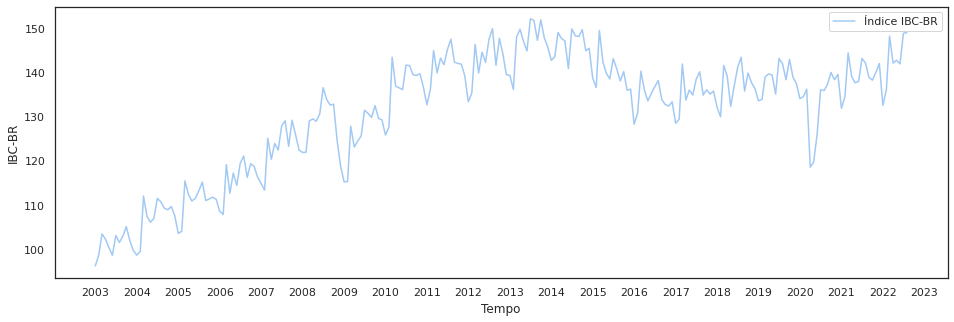

In [14]:
fig = plt.figure(figsize=(16,5))
plt.plot(df['valor'], 'b')
plt.legend(['Índice IBC-BR'])
plt.ylabel('IBC-BR')
plt.xlabel('Tempo')

# ajustamos o eixo x da figura para exibir ticks a cada ano
configurar_ticks_anuais(fig.axes[0])

plt.show()

Pelo gráfico:
- Tendência: observamos que a tendência varia ao longo do tempo (não é linear), mas que a amplitude de variação não parece aumentar ao longo do tempo.
- Sazonalidade: os dados parecem ter uma sazonalidade anual.

In [15]:
# decompomos os dados usando um modelo multiplicativo. O período selecionado é 
# de 12 meses, pois temos registros mensais e, aparentemente, uma sazonalidade 
# anual.
decomposed_series = seasonal_decompose(df, model="multiplicative", period=12)

In [16]:
def desenhar_grafico_serie_decomposta(serie_decomposta: statsmodels.tsa.seasonal.DecomposeResult) -> None:
  fig, axes = plt.subplots(3, 1, sharex=True)
  fig.set_figwidth(16)
  fig.set_figheight(4 * 3)

  axes[0].plot(serie_decomposta.trend, 'b', label='Tendência')
  axes[0].legend()

  axes[1].plot(serie_decomposta.seasonal, 'r', label='Sazonalidade')
  axes[1].legend()

  axes[2].plot(serie_decomposta.resid, 'c', label='Resíduo')
  axes[2].legend()

  # ajustamos o eixo x da figura para exibir ticks a cada ano
  # só precisamos fazer o ajuste para um dos eixos, pois o eixo
  # x é compartilhado.
  configurar_ticks_anuais(axes[0])

  fig.show()

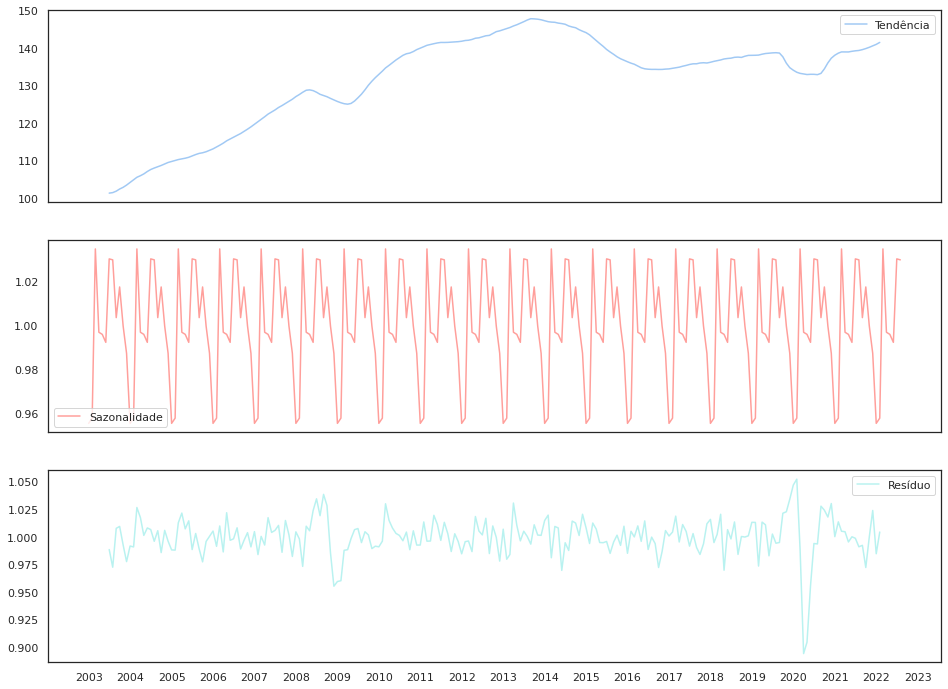

In [17]:
desenhar_grafico_serie_decomposta(decomposed_series)

Observamos nos dados que a sazonalidade é bem definida e parece que podemos analisar os componentes de tendência e residual em busca de anomalias.

#### Análise da distribuição dos dados

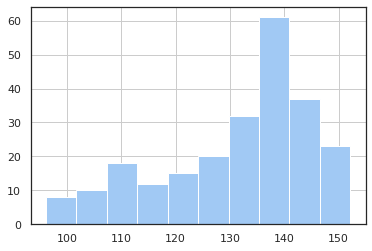

In [18]:
serie_ibcbr_valores = df.valor
serie_ibcbr_valores.hist();

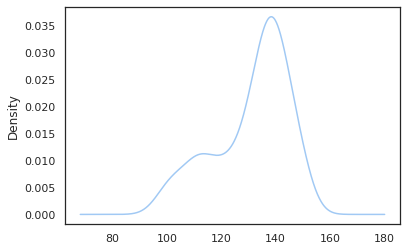

In [19]:
serie_ibcbr_valores.plot(kind='kde');

Os valores da série estão concentrados no entorno de 140.

#### Analise das propriedades estatísticas da série temporal

Precisamos entender as propriedades estatísticas de nossa série temporal ao longo do tempo, como a média e a variância, para verificar se podemos aplicar certos métodos estatísticos nos dados. Como a tendência não é linear, a série não parece ser estacionária.

Utilizaremos o método de teste [Augmented Dickey-Fuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) da biblioteca StatsModel para verificar se a série possui propriedades de uma série estacionária.

In [20]:
def criticar_pvalue_mackinnon(pvalue : float) -> str:
  """
  Critica se o valor do p-value de MacKinnon recebido como argumento
  indica se a série é ou não estacionária.
  pvalue : float que representa o p-value de MacKinnon.
  retorna : string em português do Brasil, que indica se a série deve ser
            entendida como estacionária ou não.
  """
  if pvalue < 0.05:
    return "é estacionaria"
  else:
    return "não é estacionária"

def verificar_serie_estacionaria(valores_serie : pd.Series, nome_serie:str) -> None:
  retorno_adfuller = adfuller(x=valores_serie)

  print(f'adfuller @ "{nome_serie}" => {retorno_adfuller}')

  # pela documentação da biblioteca, o segundo valor retornado
  # pelo método 'adfuller' é o valor de interesse:
  # "MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)."
  pvalue = retorno_adfuller[1]

  print(f'A série "{nome_serie}" {criticar_pvalue_mackinnon(pvalue)}.')

def sanear_array_like(array_like : np.array):
  return [x for x in array_like.values if not np.isnan(x)]

In [21]:
def verificar_entradas_invalidas(nome:str, array_like: np.array) -> None:
  print(f'Quantidade de entradas inválidas em "{nome}": {array_like.isna().sum()}')

verificar_entradas_invalidas(nome='tendência', array_like=decomposed_series.trend)
verificar_entradas_invalidas(nome='sazonalidade', array_like=decomposed_series.seasonal)
verificar_entradas_invalidas(nome='resíduo', array_like=decomposed_series.resid)

Quantidade de entradas inválidas em "tendência": 12
Quantidade de entradas inválidas em "sazonalidade": 0
Quantidade de entradas inválidas em "resíduo": 12


In [22]:
# precisamos tratar as inválidas na tendência e no resíduo
# por isso usamos a função 'sanear_array_like', que criamos.
series = {
    'IBC-BR': df['valor'],
    'IBC-BR (tendência)': sanear_array_like(decomposed_series.trend),
    'IBC-BR (sazonalidade)': sanear_array_like(decomposed_series.seasonal),
    'IBC-BR (resíduo)': sanear_array_like(decomposed_series.resid)
}

for nome_serie, valores_serie in series.items():
  verificar_serie_estacionaria(valores_serie=valores_serie,
                               nome_serie=nome_serie)
  print('-' * 10)

adfuller @ "IBC-BR" => (-2.1967002259190505, 0.2074452636799229, 15, 220, {'1%': -3.4604283689894815, '5%': -2.874768966942149, '10%': -2.57382076446281}, 1128.2442344045637)
A série "IBC-BR" não é estacionária.
----------
adfuller @ "IBC-BR (tendência)" => (-2.11100573104252, 0.24011223255929676, 13, 210, {'1%': -3.461878735881654, '5%': -2.875403665910809, '10%': -2.574159410430839}, -222.51659403949532)
A série "IBC-BR (tendência)" não é estacionária.
----------
adfuller @ "IBC-BR (sazonalidade)" => (-344962921165509.3, 0.0, 12, 223, {'1%': -3.460018927623594, '5%': -2.8745897386146817, '10%': -2.57372514086348}, -14914.2875443674)
A série "IBC-BR (sazonalidade)" é estacionaria.
----------
adfuller @ "IBC-BR (resíduo)" => (-8.9922195277069, 6.843091351066851e-15, 6, 217, {'1%': -3.460849270544952, '5%': -2.87495318813585, '10%': -2.5739190539191745}, -1142.0215233786612)
A série "IBC-BR (resíduo)" é estacionaria.
----------


Confirmamos que a série não é estacionária e que a tendência é o motivo, pois tanto a sazonalidade quanto o resíduo são estacionários.

O resíduo é uma série estacionária e, pela análise visual, parece um bom candidato para detectarmos as anomalias, mas é ela depende da decomposição da série original e contém valores nulos (NaNs - "not a number"), por isso também verificaremos se a série formada pela pela diferença de valores consecutivos é uma série estacionária.

### Construção da série de diferenças

Vamos construir uma série baseada na diferença entre valores consecutivos na série original e verificar se essa nova série é uma boa opção (se contém as anomalias observadas visualmente e se apresenta propriedades estatísticas desejáveis).

In [23]:
serie_diff_valores = np.diff(df['valor'])

In [24]:
serie_diff_valores.shape

(235,)

In [25]:
# ignoramos o primeiro valor da série, pois o np.diff não gera o primeiro valor
x_tempo = df.index.to_numpy().squeeze()[1:]

# construímos um dataframe com os dados, para facilitar a manipulação
df_diff = pd.DataFrame( data=serie_diff_valores, 
                        index=x_tempo, 
                        columns=['valor_diferenca'] )

In [26]:
df_diff.describe()

,valor_diferenca
count,235.000000
mean,0.224936
std,4.766774
min,-17.670000
25%,-2.730000
50%,-0.320000
75%,2.285000
max,15.830000


In [27]:
# verificando se há valores nulos na série de diferenças
# (não deveriam existir)
df_diff.isna().sum()

valor_diferenca    0
dtype: int64

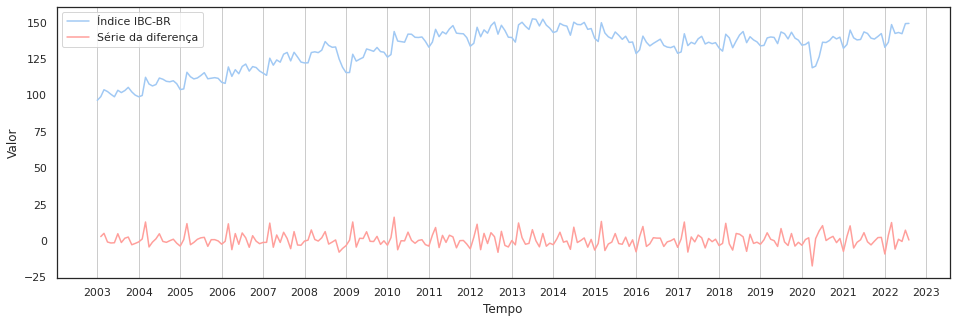

In [28]:
# vamos imprimir um gráfico com os valores da série original e os 
# valores da série de diferenças, para fazer uma análise visual.
fig = plt.figure(figsize=(16,5))

plt.plot(df['valor'], 'b')
plt.plot(df_diff['valor_diferenca'], 'r')

plt.legend(['Índice IBC-BR', 'Série da diferença'])
plt.ylabel('Valor')
plt.xlabel('Tempo')

# ajustamos o eixo x da figura para exibir ticks a cada ano
configurar_ticks_anuais(fig.axes[0])
plt.grid(axis='x')

plt.show()

#### Decomposição da série de diferenças

Decompomos a série de diferenças para poder comparar se os resíodos das duas séries possuem as características desejadas.

In [29]:
# decompomos os dados da série de diferença utilizando o modelo aditivo,
# pois não parece existir tendência nos dados. Também mantivemos o mesmo
# período de 12 meses para avaliar a sazonalidade.
decomposed_diff_series = seasonal_decompose(df_diff,
                                            model="additive",
                                            period=12 )

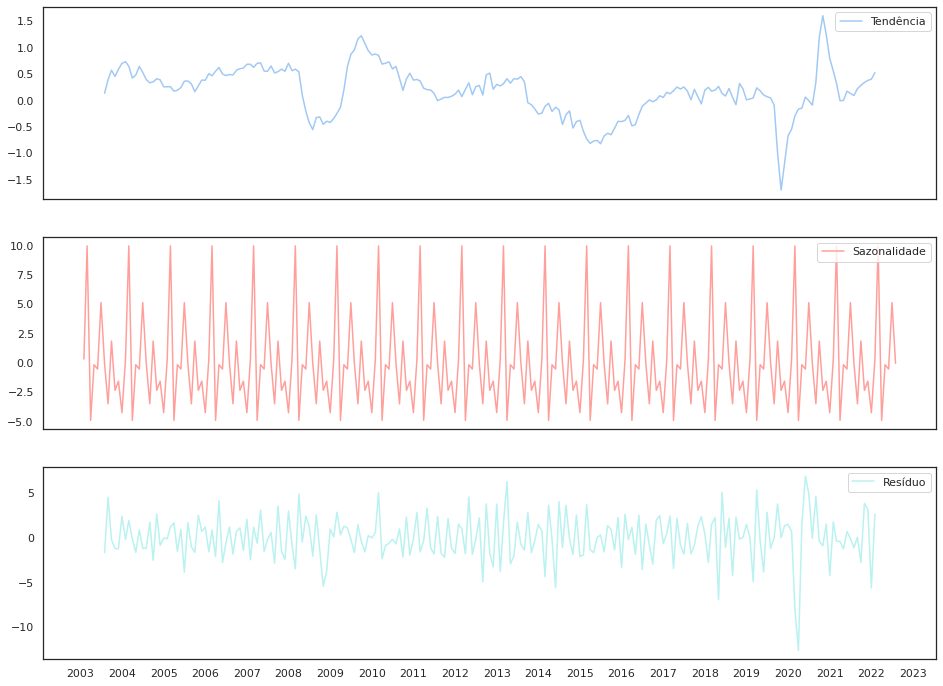

In [30]:
desenhar_grafico_serie_decomposta(decomposed_diff_series)

#### Comparação entre os resídos da série original e da série de diferenças

Verificamos onde ocorrem os NaNs no resíduo das duas séries decompostas, para verificar se os locais são equivalentes nelas.

In [31]:
def obter_indice_nans(array_like: np.array) -> np.array:
  return [idx for idx in range(len(array_like)) if np.isnan(array_like[idx])]

In [32]:
indices_nans_residuo_serie_original = obter_indice_nans(decomposed_series.resid)
display(indices_nans_residuo_serie_original)

[0, 1, 2, 3, 4, 5, 230, 231, 232, 233, 234, 235]

In [33]:
indices_nans_residuo_serie_diferencas = obter_indice_nans(decomposed_diff_series.resid)
display(indices_nans_residuo_serie_diferencas)

[0, 1, 2, 3, 4, 5, 229, 230, 231, 232, 233, 234]

Concluímos que os locais onde os NaNs aparecem nos resíduos das duas séries são compatíveis. Com isto posto, verificamos, visualmente, se os picos e vales ocorrem com propriedades similares nas duas séries.

In [34]:
def normalizar_array_like(array_like: np.array) -> np.array:
  """
  Normaliza os valores em um array like do Numpy e os desloca para a origem.
  array_like : objeto de entrada, que pertence à classe
               de array likes do Numpy. Não pode conter
               valores nulos ou NaN.
  returna uma cópia do array com os dados normalizados.
  """
  if np.isnan(array_like).sum() > 0:
    raise ValueError('Input array should not contain null-like values.')
  mean = np.mean(array_like)
  array_like_at_origin = array_like - mean
  max = np.max(np.abs(array_like_at_origin))
  return (array_like_at_origin) / max # np.linalg.norm(array_like)

In [35]:
# normalizamos os dados de resíduo para poder comparar os pontos onde anomalias
# podem ser observadas no gráfico.

residuo_original_normalizado = normalizar_array_like( 
    sanear_array_like( decomposed_series.resid ) )

residuo_diferencial_normalizado = normalizar_array_like( 
    sanear_array_like( decomposed_diff_series.resid ) )

Desenhamos um gráfico do resíodo das duas séries, para comparação visual.

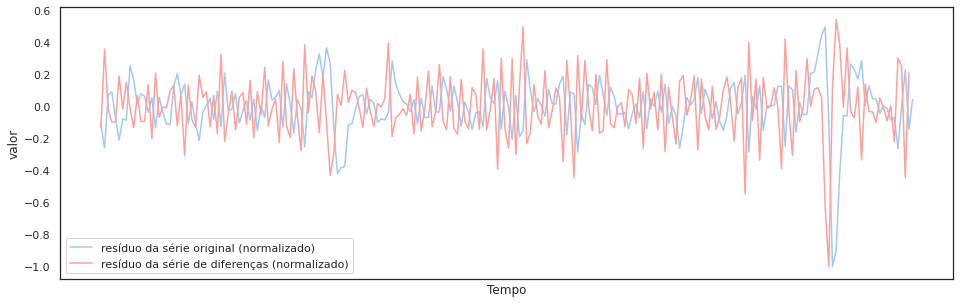

In [36]:
fig = plt.figure(figsize=(16,5))
plt.plot(residuo_original_normalizado, 'b')
plt.plot(residuo_diferencial_normalizado, 'r')
plt.legend( ['resíduo da série original (normalizado)', 
             'resíduo da série de diferenças (normalizado)'] )
plt.ylabel('valor')
plt.xlabel('Tempo')
plt.grid(axis='x')

# ajustamos o eixo x da figura para exibir ticks a cada ano
configurar_ticks_anuais(fig.axes[0])

plt.show()

A comparação visual indica que a série da diferença de dois valores consecutivos parece ser um bom _proxy_ da série original, no que tange a análise do aspecto residual para a identificação de anomalias.

#### Análise das propriedades estatísticas da série de diferenças

Verificamos as propriedades estatística da série de diferenças para saber se ela é estacionária, como suspeitamos inicialmente, e concluímos que ela é estacionária.

In [78]:
verificar_serie_estacionaria( nome_serie="IBC-BR (diferenças)",
                              valores_serie=df_diff )

adfuller @ "IBC-BR (diferenças)" => (-3.8485616986608804, 0.0024477660486544412, 14, 220, {'1%': -3.4604283689894815, '5%': -2.874768966942149, '10%': -2.57382076446281}, 1127.3878918640276)
A série "IBC-BR (diferenças)" é estacionaria.


In [79]:
verificar_serie_estacionaria( nome_serie="IBC-BR (resíduo diferenças)", 
                              valores_serie=sanear_array_like( 
                                  decomposed_diff_series.resid ) )

adfuller @ "IBC-BR (resíduo diferenças)" => (-8.423516014273224, 1.9545659792710852e-13, 15, 207, {'1%': -3.4623415245233145, '5%': -2.875606128263243, '10%': -2.574267439846904}, 910.1227944361123)
A série "IBC-BR (resíduo diferenças)" é estacionaria.


### Análise da média móvel

Escrevemos algumas funções e procedimentos utilitários para facilitar a análise da média móvel.

In [38]:
def montar_dataframe_media_movel(dataframe:pd.DataFrame, 
                                 window_size:int=12) -> pd.DataFrame:
  """
  Monta um DataFrame que contém a média móvel com janela de
  tamanho 'window_size' unidades para o 'dataframe' recebido
  como argumento.
  dataframe : DataFrame pandas para o qual se deseja calcular a média móvel.
  window_size : quantas unidades (índices) do dataframe serão usados para
                calcular a média móvel.
  return : retorna um DataFrame pandas com a média móvel calculada.
  """
  if window_size <= 0:
    raise ValueError('The window size must be greater than zero.')
  
  if window_size > len(dataframe):
    raise ValueError('The window size must be smaller than the DataFrame.')
  
  # calculamos a média móvel de 'window_size' registros consecutivos
  df_moving_average = dataframe.rolling(window=window_size).sum() / window_size

  # ignoramos os 'window_size' primeiros valores da média móvel,
  # pois não levam em consideração uma janela completa.
  df_moving_average = df_moving_average[window_size + 1:]

  return df_moving_average

def desenhar_grafico_media_movel(series:pd.Series,
                                 series_label:str,
                                 moving_average_series:pd.Series,
                                 moving_average_series_label:str) -> None:
  """
  Procedimento auxiliar para desenhar o valor de uma série versus o valor
  de sua média móvel.
  series : série original.
  series_label : label (string) para a legenda da série original.
  moving_average_series : série que representa a média móvel.
  moving_average_series_label : label (string) para a legenda da série
                                da média móvel.
  Não retorna resultados.
  """
  # visualizamos os dados e a média móvel em conjunto,
  # aplicando um offset de 'window_size' nos dados, pois
  # não temos valores da média móvel para os primeiros
  # 'window_size' registros dos dados.
  fig = plt.figure(figsize=(16,5))

  plt.plot(series, 'b', label=series_label)
  plt.plot(moving_average_series, 'r', label=moving_average_series_label)

  configurar_ticks_anuais(fig.axes[0])

  plt.grid(axis='x')

  plt.legend()
  plt.show()

#### Média móvel da série original

Calculamos a média móvel da série original, com o período da sazonalidade aparente (12 meses), para entender como ela se relaciona com os dados.

In [39]:
df_moving_average = montar_dataframe_media_movel(dataframe=df, window_size=12)

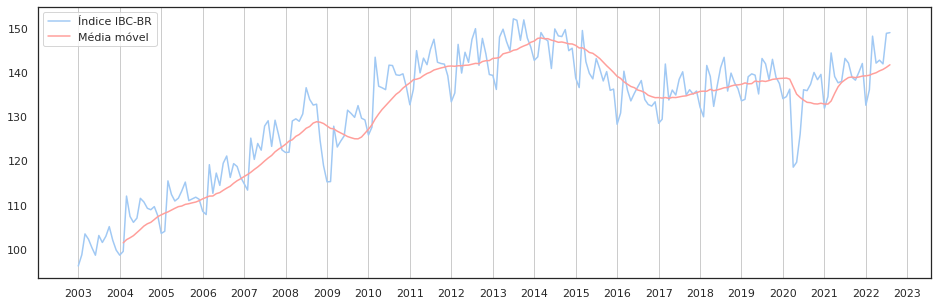

In [40]:
desenhar_grafico_media_movel(series=df['valor'],
                             series_label='Índice IBC-BR',
                             moving_average_series=df_moving_average,
                             moving_average_series_label='Média móvel')

#### Média móvel da série de diferenças

In [41]:
df_diff_moving_average = montar_dataframe_media_movel(dataframe=df_diff, 
                                                      window_size=12)

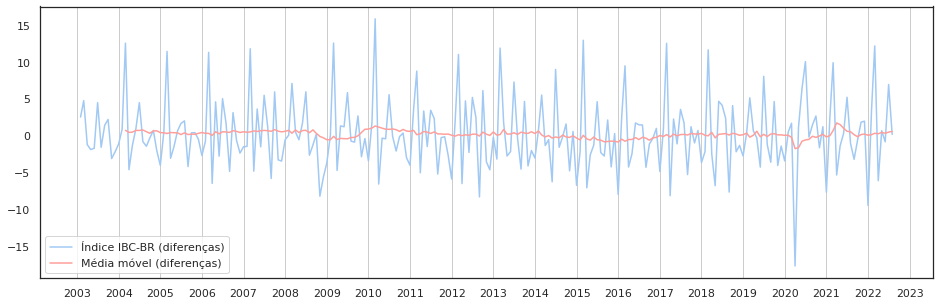

In [42]:
desenhar_grafico_media_movel(
    series=df_diff['valor_diferenca'],
    series_label='Índice IBC-BR (diferenças)',
    moving_average_series=df_diff_moving_average,
    moving_average_series_label='Média móvel (diferenças)')

### Análise da autocorrelação dos dados

Analisamos a autocorrelação dos registros (a relação de um valor da série temporal com valor que esteja deslocado deste registro no tempo em n unidades) para a série temporal em si e para as componentes de tendência, sazonalidade e resíduo. 

Verificamos valores distantes em até 24 unidades de um dado valor.

Através do processo analítico, verifica-se que os valores da série temporal estão fortemente relacionados com valores distantes com múltiplos de 12 de seus próprios registros e que os valores mais próximos possuem uma correlação mais forte.

In [43]:
def aux_visualizar_autocorrelacao(rotulo:str, f_estrategia_desenho) -> None:
  """
  Função auxiliar para desenhar as autocorrelações.
  rotulo : nome da série, da forma que será exibido na legenda.
  f_estrategia_desenho : procedimento sem parâmetros que implementa a estratégia
                         de desenho no objeto gráfico corrente.
  returno: nenhum.  
  """
  fig = plt.figure(figsize=(16,4))
  
  plt.title(f'Autocorrelação ({rotulo})')
  plt.xlabel('Lag da correlação (meses)')
  
  plt.grid(True)

  # configuramos o tick do eixo 'x' para ocorrer
  # em números pares.
  fig.axes[0].xaxis.set_major_locator(mticker.MultipleLocator(base=2))

  # executa a estratégia de desenho
  f_estrategia_desenho(fig.axes[0])
  plt.show()

def visualizar_autocorrelacao_matplotlib(dados, maxlags, rotulo='série temporal'):
  # estrategia de desenho via matplotlib
  def executar_desenho(axes : plt.axes) -> None:
    plt.acorr(dados, maxlags=maxlags, lw=2)
  
  aux_visualizar_autocorrelacao(rotulo, executar_desenho)

def visualizar_autocorrelacao_statsmodels(dados, maxlags, rotulo='série temporal'):
  # estrategia de desenho via statsmodels
  def executar_desenho(axes : plt.axes) -> None:
    plot_acf(dados, ax=axes, lags=maxlags)

  aux_visualizar_autocorrelacao(rotulo, executar_desenho)

def visualizar_autocorrelacao_parcial_statsmodels(dados, maxlags, rotulo='série temporal'):
  # estrategia de desenho via statsmodels (autocorrelação parcial)
  def executar_desenho(axes : plt.axes) -> None:
    plot_pacf(dados, ax=axes, lags=maxlags, method="ywm")

  aux_visualizar_autocorrelacao(rotulo, executar_desenho)

#### Autocorrelação da série original

Os dados da série histórica IBC-BR estão autocorrelacionados, como esperávamos.

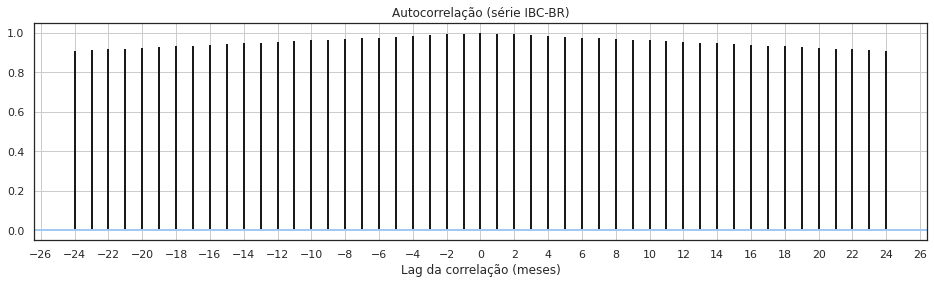

In [44]:
visualizar_autocorrelacao_matplotlib( df['valor'], 
                                      maxlags=24, 
                                      rotulo='série IBC-BR')

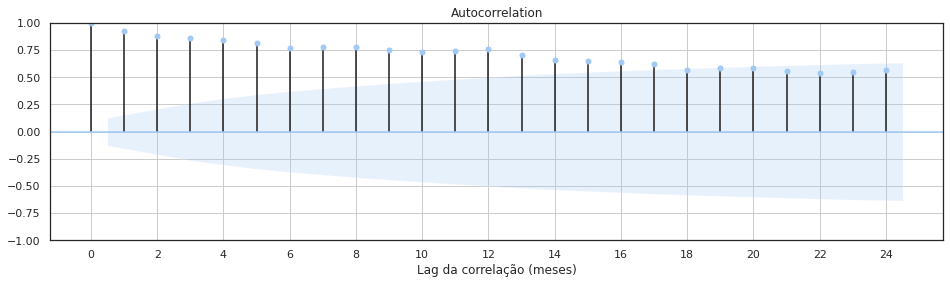

In [45]:
visualizar_autocorrelacao_statsmodels( df['valor'], 
                                       maxlags=24, 
                                       rotulo='série IBC-BR')

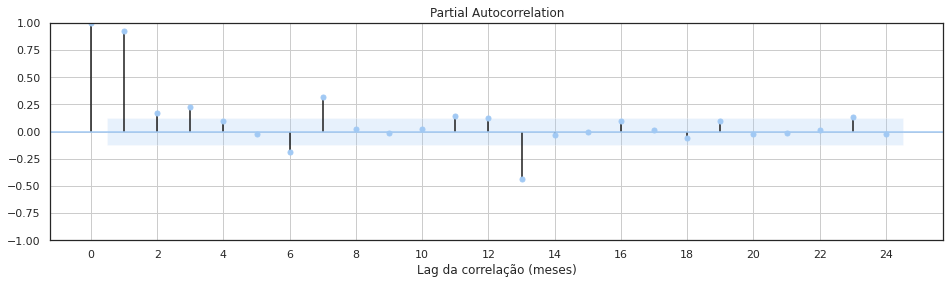

In [46]:
visualizar_autocorrelacao_parcial_statsmodels( df['valor'], 
                                               maxlags=24, 
                                               rotulo='série IBC-BR')

A tendência não está autocorrelacionada (como também esperávamos).

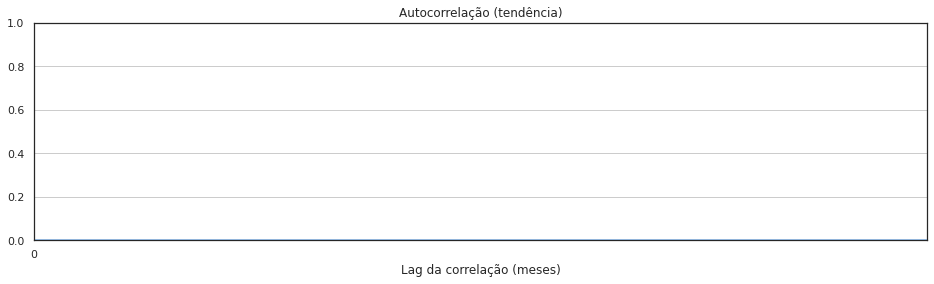

In [47]:
visualizar_autocorrelacao_matplotlib( decomposed_series.trend, 
                                      maxlags=24, 
                                      rotulo='tendência')

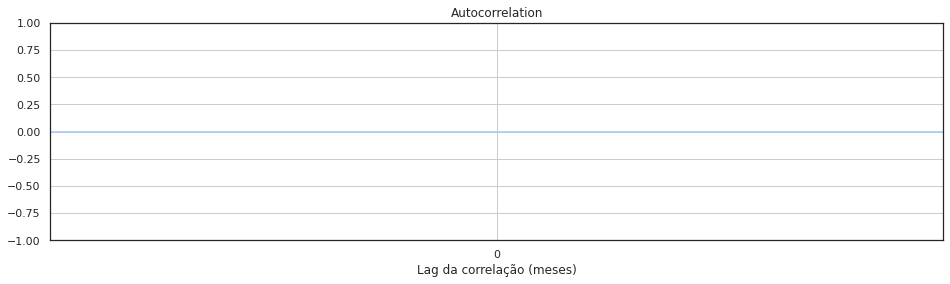

In [48]:
visualizar_autocorrelacao_statsmodels( decomposed_series.trend, 
                                       maxlags=24, 
                                       rotulo='tendência')

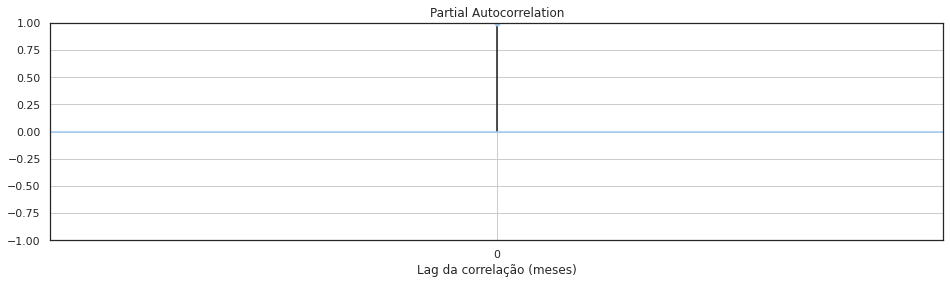

In [49]:
visualizar_autocorrelacao_parcial_statsmodels( decomposed_series.trend, 
                                               maxlags=24, 
                                               rotulo='tendência')

A sazonalidade realmente está fortemente autocorrelacionada com registros distantes em 12 meses (lag de 12 unidades), como assumimos. Também percebemos que está autocorrelacionada de forma negativa com valores com lag de seis meses.

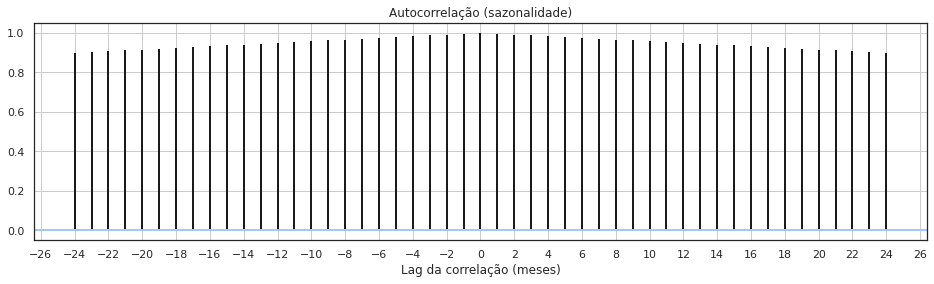

In [50]:
visualizar_autocorrelacao_matplotlib( decomposed_series.seasonal, 
                                      maxlags=24, 
                                      rotulo='sazonalidade')

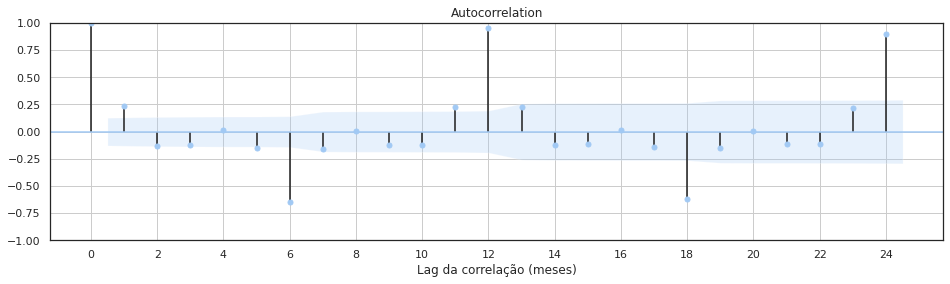

In [51]:
visualizar_autocorrelacao_statsmodels( decomposed_series.seasonal, 
                                       maxlags=24, 
                                       rotulo='sazonalidade')

Os valores residuais (quando se remove a tendência e a sazonalidade) não estão autocorrelacionados (como é esperado).

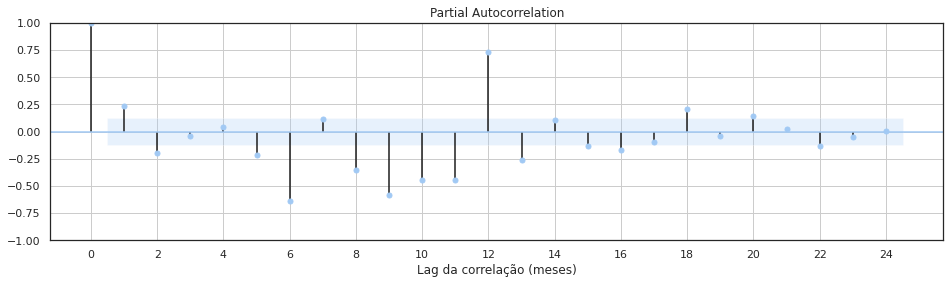

In [52]:
visualizar_autocorrelacao_parcial_statsmodels( decomposed_series.seasonal, 
                                               maxlags=24, 
                                               rotulo='sazonalidade')

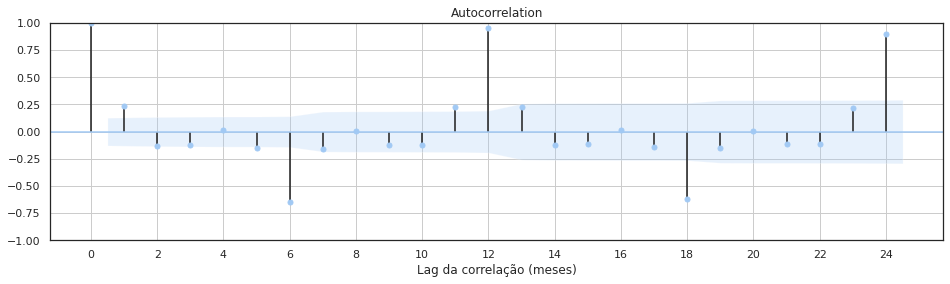

In [53]:
visualizar_autocorrelacao_statsmodels( decomposed_series.seasonal, 
                                       maxlags=24, 
                                       rotulo='sazonalidade')

Analisamos o resíduo da série original. Não esperamos encontrar valores autocorrelacionados no resíduo da série.

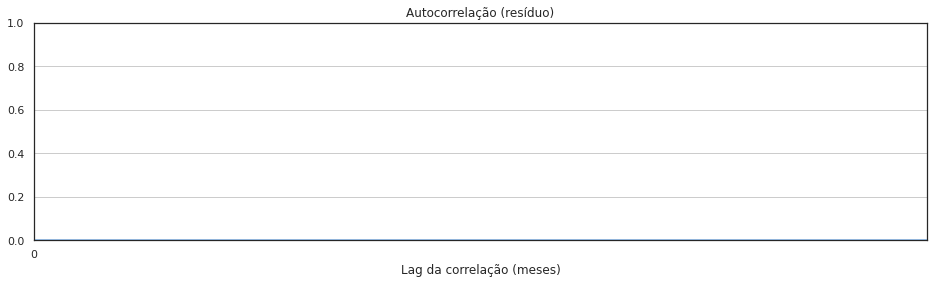

In [54]:
visualizar_autocorrelacao_matplotlib( decomposed_series.resid, 
                                      maxlags=24,
                                      rotulo='resíduo')

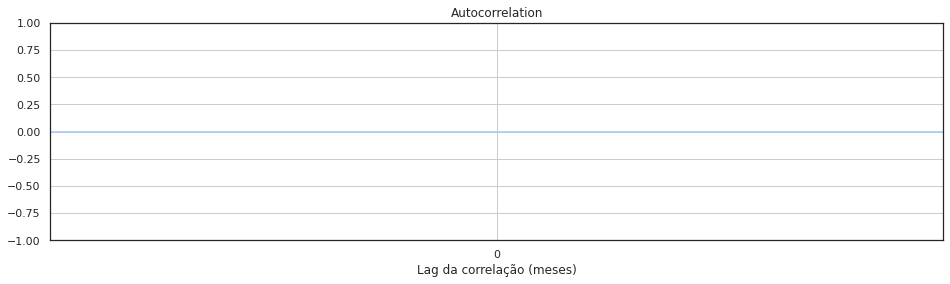

In [55]:
visualizar_autocorrelacao_statsmodels( decomposed_series.resid, 
                                       maxlags=24,
                                       rotulo='resíduo')

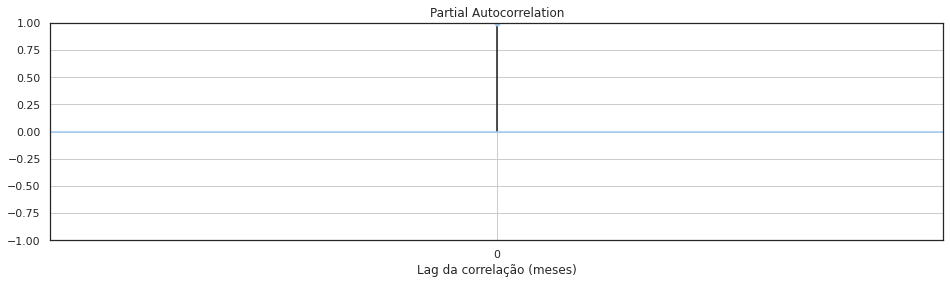

In [56]:
visualizar_autocorrelacao_parcial_statsmodels( decomposed_series.resid, 
                                               maxlags=24,
                                               rotulo='resíduo')

#### Autocorrelação da série de diferenças

Analisando a autocorrelação da série de diferenças, observamos uma autocorrelação forte com períodos distantes com módulo de doze meses da amostra, sendo que os valores mais próximos (lag de doze meses) estão mais fortemente correlacionados nessa série. Também observamos uma autocorrelação negativa com valores com lag de seis meses.

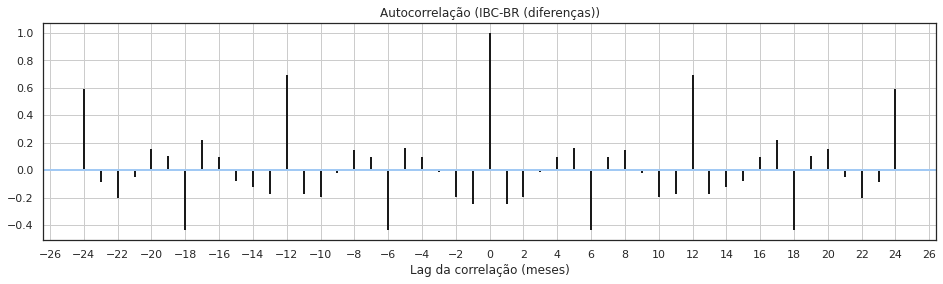

In [57]:
visualizar_autocorrelacao_matplotlib( df_diff['valor_diferenca'], 
                                      maxlags=24,
                                      rotulo='IBC-BR (diferenças)')

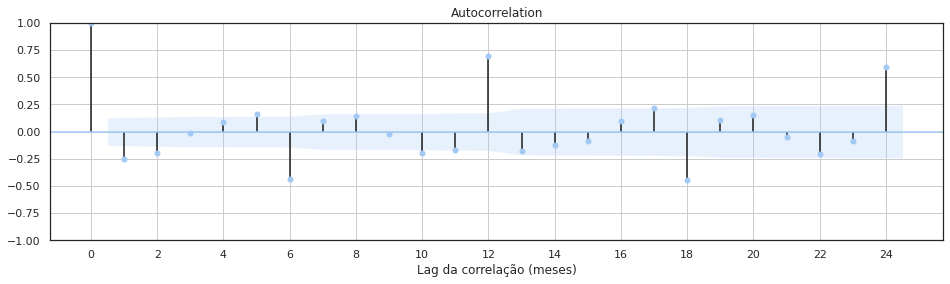

In [58]:
visualizar_autocorrelacao_statsmodels( df_diff['valor_diferenca'], 
                                       maxlags=24,
                                       rotulo='IBC-BR (diferenças)')

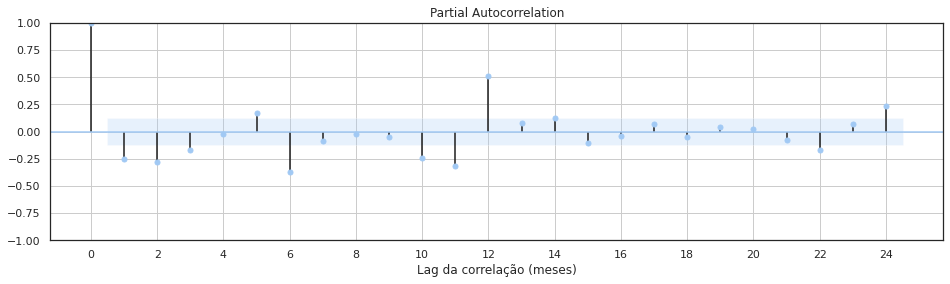

In [59]:
visualizar_autocorrelacao_parcial_statsmodels( df_diff['valor_diferenca'], 
                                               maxlags=24,
                                               rotulo='IBC-BR (diferenças)')

Analisamos agora somente o resíduo da série de diferenças, para confirmar a hipótese de que os valores não estão autocorrelacionados.

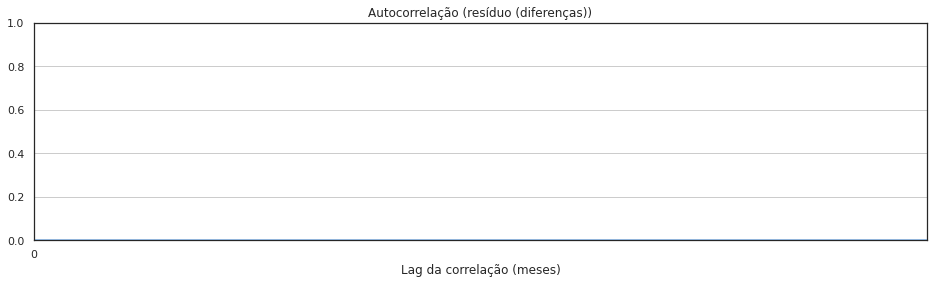

In [60]:
visualizar_autocorrelacao_matplotlib( decomposed_diff_series.resid, 
                                      maxlags=24,
                                      rotulo='resíduo (diferenças)')

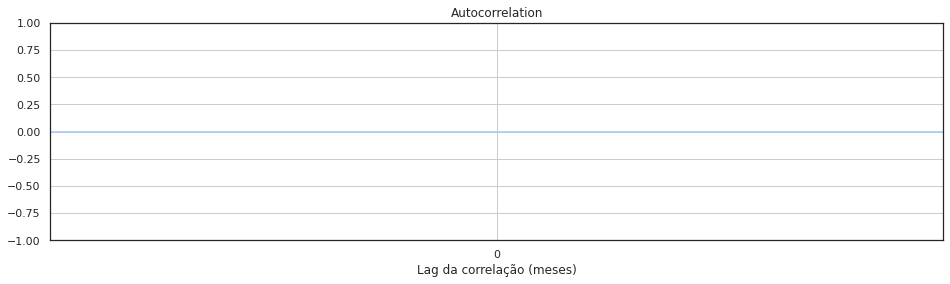

In [61]:
visualizar_autocorrelacao_statsmodels( decomposed_diff_series.resid, 
                                       maxlags=24,
                                       rotulo='resíduo (diferenças)')

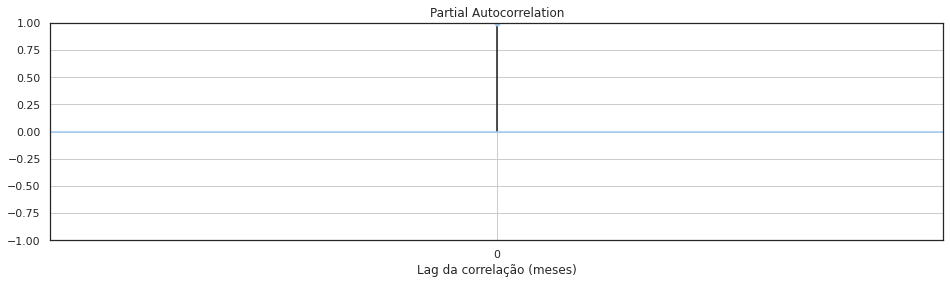

In [62]:
visualizar_autocorrelacao_parcial_statsmodels( decomposed_diff_series.resid, 
                                               maxlags=24,
                                               rotulo='resíduo (diferenças)')

### Resumo da análise da série IBC-BR

Após analisarmos a série histórica do IBC-BR, vemos que:

* A série histórica do IBC-BR está autocorrelacionada positivamente com valores com _lag_ de doze meses.
* A série histórica do IBC-BR está autocorrelacionada negativamente com valores com _lag_ de seis meses.
* A série histórica do IBC-BR não é estacionária.
* A tendência da série histórica do IBC-BR não é linear.
* Aparentemente, as anomalias da série histórica do IBC-BR podem ser encontradas no resíduo da série, após sua decomposição.
* Uma nova série histórica pode ser derivada da série IBC-BR fazendo a diferença de valores consecutivos da série original (doravante chamaremos esta série de "série de diferenças").
* A série de diferenças é estacionária.
* Aparentemente, as anomalias da série original ainda podem ser encontradas na série de diferenças.
* Como a série de diferenças também é estacionária, esta poderá ser analisada por métodos estatísticos para tentarmos identificar as anomalias nos dados.

A construção da série de diferenças nos permite fazer a deteção de anomalias sem ter que decompor a série que se quer testar. Isso é importante para simplificar um eventual sistema de deteção de anomalias que emule um comportamento de análise de streaming.

## Persistindo os dados selecionados

Antes de persistir os dados, vamos padronizar os nomes das colunas para 'data'
e 'valor'. Também vamos limpar os valores inválidos.

In [63]:
def padronizar_nomes_colunas(dataframe:pd.DataFrame) -> None:
  """
  Padroniza os nomes do índice e da coluna do dataframe de coluna
  unitária recebido como argumento.
  """
  dataframe.index.rename('data', inplace=True)
  dataframe.columns = ['valor']

In [64]:
# apesar do dataframe original já estar padronizado
# nós aplicamos as mesmas transformações, por simetria
# e para garantir que tudo irá continuar da mesma forma
# ao longo do tempo. Não removemos valores inválidos,
# pois, se chegamos até aqui, eles não devem existir.
padronizar_nomes_colunas(df)

In [65]:
df.shape # haviam 236 valores quando analisamos os dados

(236, 1)

In [66]:
# padronizando o resíduo da série original
df_resid = pd.DataFrame(decomposed_series.resid).dropna()
padronizar_nomes_colunas(df_resid)

In [67]:
df_resid.shape # haviam 224 valores quando analisamos os dados

(224, 1)

In [68]:
# padronizando a série de diferenças
padronizar_nomes_colunas(df_diff)
df_diff.dropna(inplace=True)

In [69]:
df_diff.shape # haviam 235 valores quando analisamos os dados

(235, 1)

In [70]:
# padronizando o resíduo da série de diferenças
df_diff_resid = pd.DataFrame(decomposed_diff_series.resid).dropna()
padronizar_nomes_colunas(df_diff_resid)

In [71]:
df_diff_resid.shape # haviam 223 valores quando analisamos os dados

(223, 1)

Por fim, salvamos os dados para os utilizar nas etapas de treinamento de modelos e detecção de anomalias.

In [72]:
# função auxiliar para salvar os dados
def salvar_dados_serie(dataframe:pd.DataFrame, nome_arquivo:str) -> None:
  caminho_saida = os.path.join(NOME_DIRETORIO_SAIDA, nome_arquivo)
  dataframe.to_csv(caminho_saida, encoding="utf8")

In [73]:
# nesse ponto, criamos o diretório que irá conter os
# dados de saída, caso ele não exista
path_saida = Path('.') / NOME_DIRETORIO_SAIDA
path_saida.mkdir(parents=False, exist_ok=True)
print(f'O caminho "{path_saida.resolve()}" {"é um diretório" if path_saida.is_dir() else "não é um diretório"} agora.')

O caminho "/content/dados" é um diretório agora.


In [74]:
# salvando os arquivos com os dados da série original
salvar_dados_serie(df, NOME_ARQUIVO_SAIDA_SERIE_IBCBR)
salvar_dados_serie(df_resid, 
                   NOME_ARQUIVO_SAIDA_SERIE_IBCBR_RESIDUO)

# salvando os arquivos com os dados da série de diferenças
salvar_dados_serie(df_diff, NOME_ARQUIVO_SAIDA_SERIE_IBCBR_DIFERENCAS)
salvar_dados_serie(df_diff_resid, 
                   NOME_ARQUIVO_SAIDA_SERIE_IBCBR_DIFERENCAS_RESIDUO)

Por fim, verificamos os nomes e tamanhos dos arquivos de saída, para ver se está tudo dentro do esperado.

In [75]:
print('Arquivos no diretório de saída:')
for elem in sorted(path_saida.iterdir()):
  if elem.is_file():
    print(f'- "{elem}", com {elem.stat().st_size} bytes')

Arquivos no diretório de saída:
- "dados/serie_ibcbr.csv", com 4229 bytes
- "dados/serie_ibcbr_diferencas.csv", com 7006 bytes
- "dados/serie_ibcbr_diferencas_residuo.csv", com 6782 bytes
- "dados/serie_ibcbr_residuo.csv", com 6690 bytes
